In [1]:
import os
import pprint
import gensim
import multiprocessing
from scipy.interpolate import spline
from scipy.fftpack import fft, ifft
import string

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
from English_to_IPA import conversion
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from num2words import num2words

In [5]:
class LyricsIterator(object):
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
    def __iter__(self):
        lyrics_data = pd.read_csv(self.dataset_name)
        for lyric in lyrics_data["text"]:
            yield split_lyric(lyric)

In [6]:
#lyrics = LyricsIterator('LyricsFreak.csv')

In [7]:
categories = ['Oral Cavity',
              'Mouth Openness',
              'Obstruent',
              'Tongue Positioning',
              'Resonance',
              'Vowel','Round','Tense']
eSPEDict = dict()
with open('eSPEPhonologicalTableV2') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDict[line[0]] = np.array([eval(x) for x in line[1:]])

In [8]:
def split_lyric(lyrics):
    lyrics = re.sub('\n+', '\n', lyrics)
    splitted_lyrics = re.sub(' +', ' ', clean_lyric(lyrics)).split(' ')
    return [ word.lower() for word in splitted_lyrics if word != '']

def clean_lyric(lyric):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    return lyric    
    
def is_number(word):
    try:
        int(word)
        return True
    except ValueError:
        pass
    return False

def change_number_to_string(number):
    return num2words(int(number))

def is_empty(sequence):
    if len(sequence) == 0:
        return True
    return False

In [30]:
def get_score_from_lyric(lyrics):
    word_count = 0
    score = np.zeros((8,), dtype=np.int)
    words = split_lyric(lyrics)
    for word in words:
        if word == '':
            continue
        if is_number(word):
            #print("Found number: "+ word)
            word = change_number_to_string(word)
        
        cmu, ipa = conversion.convert(word)
        punct = '[ˌˈ ]'
        for p in punct:
            ipa = ipa.replace(p , '')
        if '*' in ipa:
            if word.endswith("in'"):
                word = word.replace("in'","ing")
                cmu,ipa = conversion.convert(word)
                punct = '[ˌˈ ]'
                for p in punct:
                    ipa = ipa.replace(p , '')
                if '*' in ipa:
                    #print('No IPA Found for: '+ word)
                    continue
            else:
                #print('No IPA Found for: '+ word)
                continue
        word_count += 1
        i = 0
        while i < len(ipa):
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDict[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDict[sym]
                    i += 1
    score = np.append(score, word_count)
    return score

#### This can Wait. First prove your hypothesis
def build_sentence_energy_sequence(lyric):
    punct_str = '!"#$%&\()*+,-./:;<=>/?@[\\]^_`{|}~«»'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    lyric = re.sub('\n+', '\n', lyric)
    splitted_sentences = lyric.split('\n')
    scores = []
    for sentence in splitted_sentences:
        temporal_score = get_score_from_lyric(sentence)
        if np.count_nonzero(temporal_score) > 0:
            scores.append(temporal_score)
    return scores
            
#lyrics_data["energy_sequence"] = lyrics_data['text'].apply(build_sentence_energy_sequence)

def get_score_by_sentence(lyric):
    punct_str = '!"#$%&\()*+,-./:;<=>/?@[\\]^_`{|}~«»'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    lyric = re.sub('\n+', '\n', lyric)
    splitted_sentences = lyric.split('\n')
    scores = []
    curated_sentences = []
    count = 1
    for sentence in splitted_sentences:
        temporal_score = get_score_from_lyric(sentence)
        if np.count_nonzero(temporal_score) > 0:
            curated_sentences.append(sentence)
            count += 1
            scores.append(temporal_score)
            #print(sentence)
            #print (sum(temporal_score[0:8])/temporal_score[8])
    return scores       
            
def get_score_from_word(word):
    score = np.zeros((8,), dtype=np.int)
    if word == '':
        return -1
    if is_number(word):
        word = change_number_to_string(word)
    cmu, ipa = conversion.convert(word)
    ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
    if '*' in ipa:
        if word.endswith("in'"):
            word = word.replace("in'","ing")
            cmu,ipa = conversion.convert(word)
            punct = '[ˌˈ ]'
            for p in punct:
                ipa = ipa.replace(p , '')
            if '*' in ipa:
                #print('No IPA Found for: '+ word)
                return score
        else:
            #print('No IPA Found for: '+ word)
            return score
    i = 0
    while i < len(ipa):
        if i == len(ipa)-1:
            sym = ipa[i]
            score += eSPEDict[sym]
            i += 1
        else:
            try:
                sym = ipa[i] + ipa[i+1]
                score += eSPEDict[sym]
                i += 2
            except KeyError:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
    return score

def get_score_by_word(lyric):
    punct_str = '!"#$%&\()*+,-./:;<=>/?@[\\]^_`{|}~«»\n'
    for p in punct_str:
        lyric = lyric.replace(p,' ')
    lyric = re.sub('\n+', '\n', lyric)
    splitted_words = split_lyric(lyric)
    scores = []
    for word in splitted_words:
        if word != '':
            temporal_score = get_score_from_word(word)
        if np.count_nonzero(temporal_score) > 0:
            scores.append(temporal_score) 
    return scores
                


In [15]:
lyrics_data = pd.read_csv('LyricsFreak.csv')
lyric = lyrics_data["text"][0]
#lyric = lyrics_data['text'][42183] # La vie en Rose

# By Sentence 

In [66]:
scores = get_score_by_sentence(lyric)

## Energy Frequency by Sentence/Category

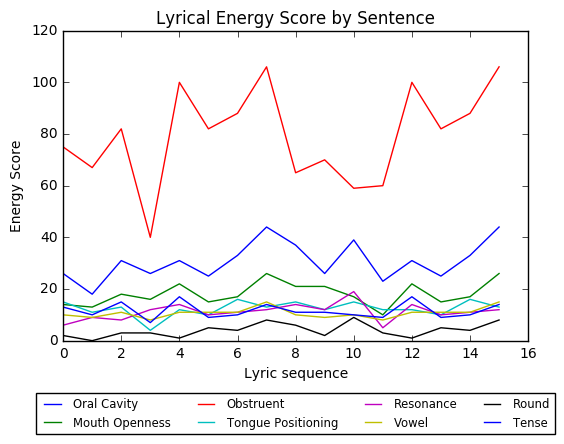

In [67]:
for i, category in enumerate(categories):
    plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

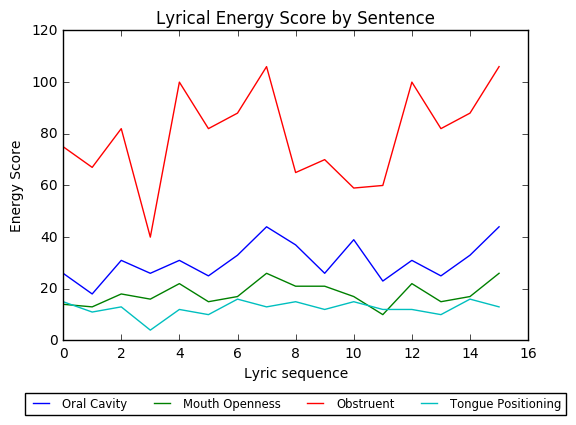

In [68]:
for i, category in enumerate(categories):
    if(i <= 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

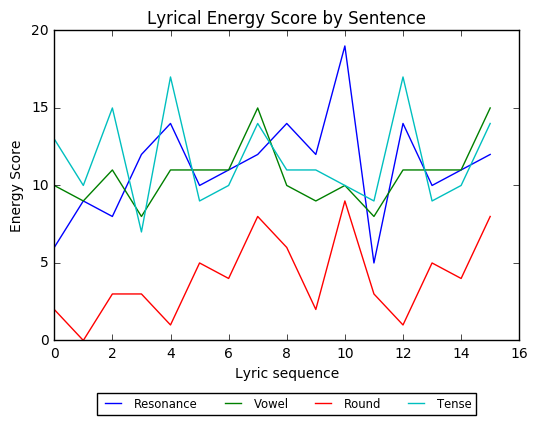

In [69]:
for i, category in enumerate(categories):
    if( i > 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.title("Lyrical Energy Score by Sentence")
plt.show()

## Overall Energy Frequency by Sentence 

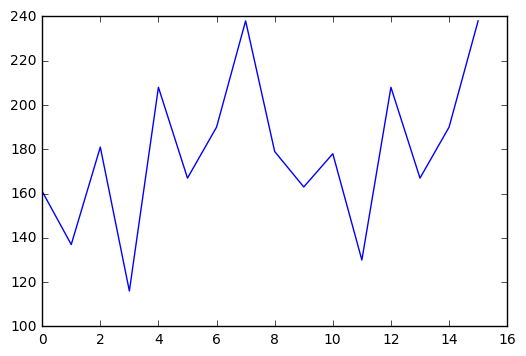

[161, 137, 181, 116, 208, 167, 190, 238, 179, 163, 178, 130, 208, 167, 190, 238]


In [70]:

fourier_norm = np.fft.fft(list(map(lambda x: sum(x[0:8])/x[8],scores)), norm='ortho')
lyric_score_by_sentence = list(map(lambda x: sum(x[0:8]),scores))

plt.plot(lyric_score_by_sentence)
#plt.plot(fourier)
#plt.plot(fourier_norm)
plt.show()
print(lyric_score_by_sentence)

## Fourier Transform - By Sentence

In [ ]:
energy_avg = list(map(lambda x: sum(x[0:8])/x[8],scores))
fourier = np.fft.fft(energy_avg)
plt.plot(fourier)
plt.show()
print(fourier)

# By word

In [71]:
scores = get_score_by_word(lyric)

## Energy Frequency by Word/Category

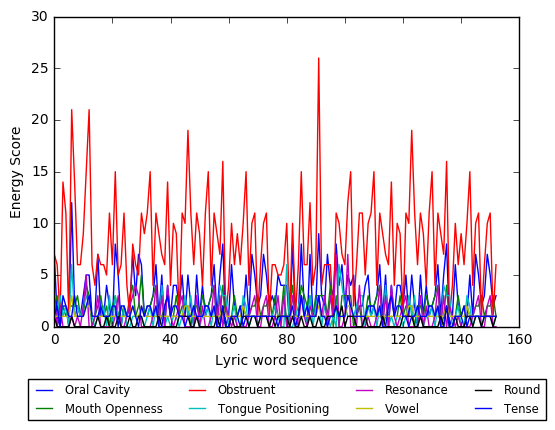

In [72]:
for i, category in enumerate(categories):
    plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

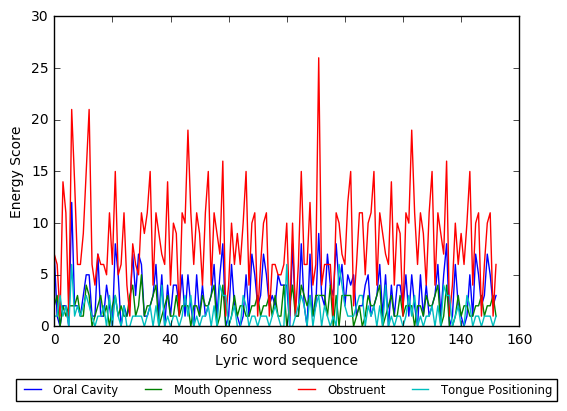

In [73]:
for i, category in enumerate(categories):
    if(i <= 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

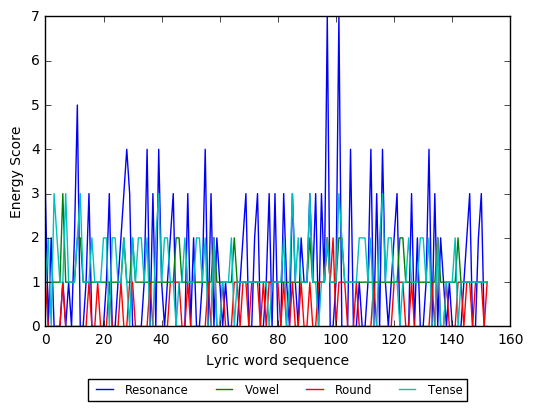

In [76]:
for i, category in enumerate(categories):
    if(i > 3):
        plt.plot(list(map(lambda x: x[i],scores)), label=category)
plt.xlabel('Lyric word sequence')
plt.ylabel('Energy Score')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=9, bbox_to_anchor=(0.5,-0.15),ncol=4)
plt.show()

## Overall Energy Frequency by Word

/Users/roblescoulter/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


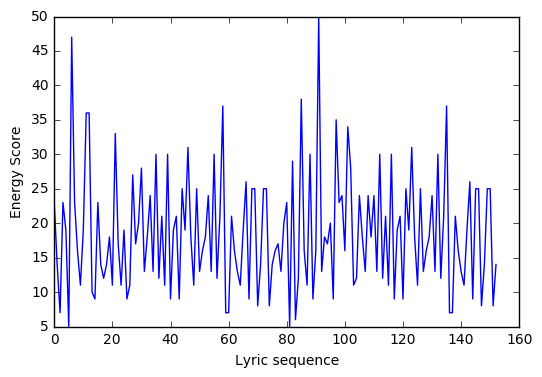

In [80]:
lyric_score_by_word = list(map(lambda x: sum(x[0:8]),scores))
plt.xlabel('Lyric sequence')
plt.ylabel('Energy Score')
plt.plot(lyric_score_by_word)
plt.legend()
plt.show()

## Fourier Transform - By Word

In [ ]:
fourier = np.fft.fft(lyric_score_by_word)
plt.plot(fourier)
plt.show()
print(fourier[:50])


# Evaluation of Energy Lyrics

In [97]:
def show_energy(file,song_name):
    temp = open(file,'r')
    lyric = temp.read()
    temp.close()
    scores = get_score_by_sentence(lyric)
    bysentence_scores = list(map(lambda x: sum(x[0:8]),scores))
    scores = get_score_by_word(lyric)
    byword_scores =  list(map(lambda x: sum(x[0:8]),scores))
    total_score = sum(byword_scores)/len(byword_scores)
    print(total_score)
    plt.xlabel('Lyric sequence')
    plt.ylabel('Energy Score')
    plt.title(song_name)
    plt.plot(byword_scores)
    plt.show()
    #plt.xlabel('Lyric sequence')
    #plt.ylabel('Energy Score')
    #for i, category in enumerate(categories):
    #    plt.plot(list(map(lambda x: x[i],scores)), label=category)
    plt.plot(bysentence_scores)
    plt.show()

19.8723404255


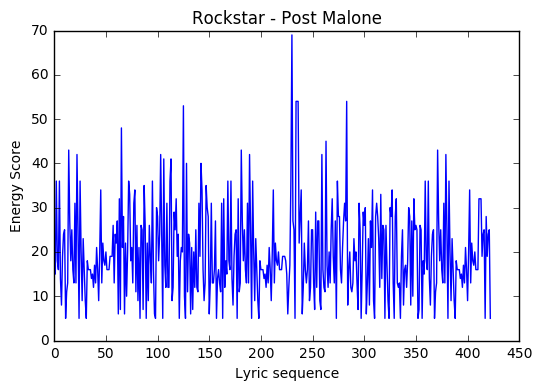

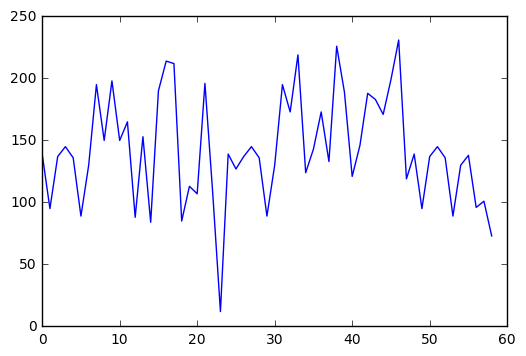

In [98]:
show_energy('GoodLyricsExamples/lyric_1.txt', 'Rockstar - Post Malone')

15.8159645233


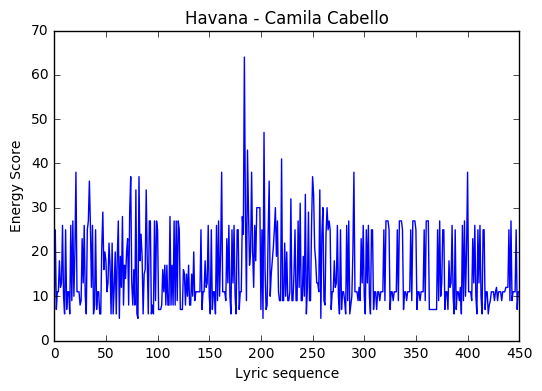

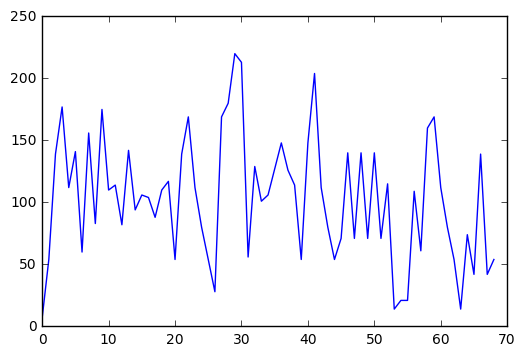

In [100]:
show_energy('GoodLyricsExamples/lyric_2.txt', 'Havana - Camila Cabello')

16.3883161512


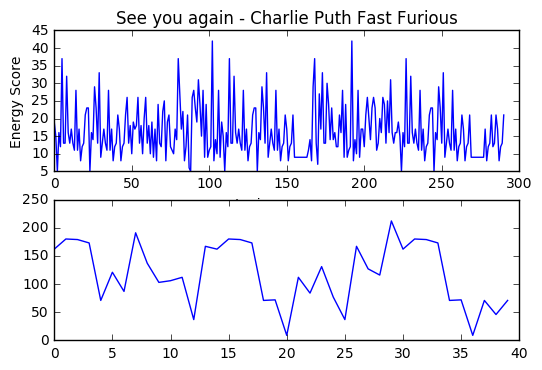

In [94]:
show_energy('GoodLyricsExamples/lyric_3.txt', 'See you again - Charlie Puth Fast Furious')

18.4654545455


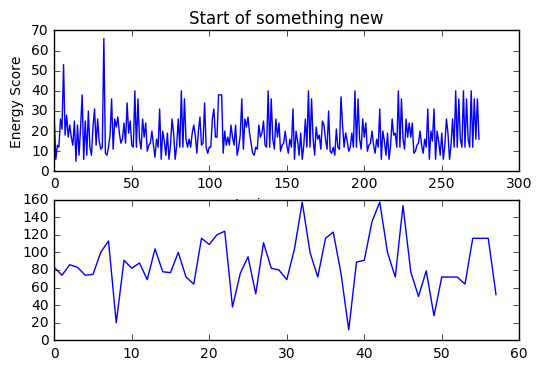

In [95]:
show_energy('GoodLyricsExamples/lyric_4.txt', 'Start of something new')

17.99609375


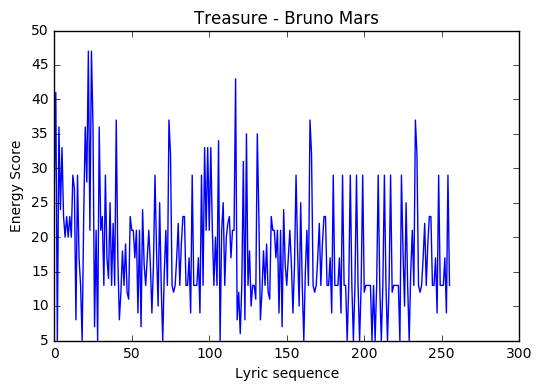

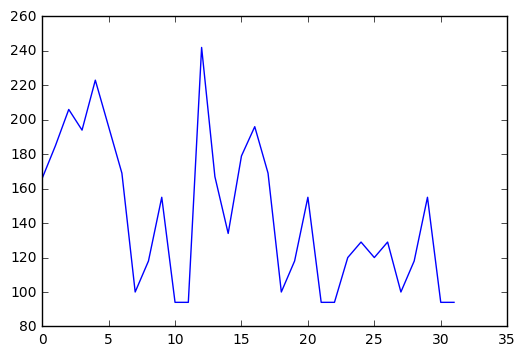

In [99]:
show_energy('GoodLyricsExamples/lyric_5.txt', 'Treasure - Bruno Mars')


17.5721393035


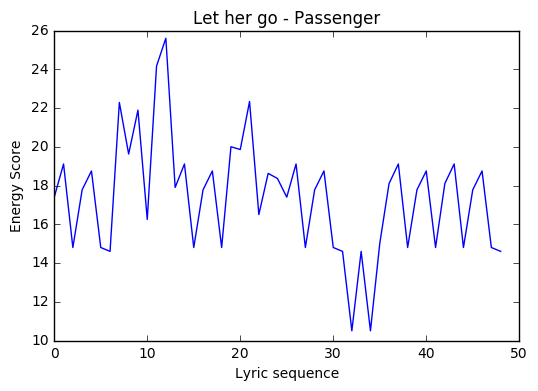

In [86]:
show_energy('GoodLyricsExamples/lyric_6.txt', 'Let her go - Passenger')

23.2197309417


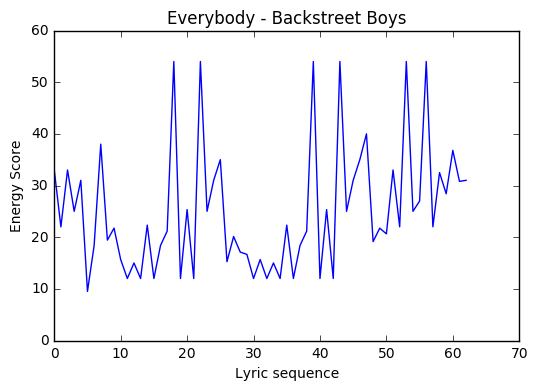

In [87]:
show_energy('GoodLyricsExamples/lyric_7.txt', 'Everybody - Backstreet Boys')

## "Bad" Lyrics

19.7161290323


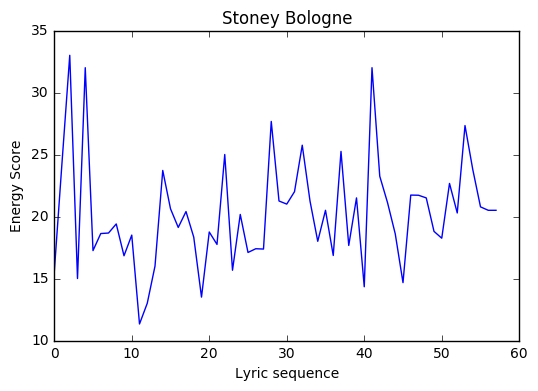

In [88]:
show_energy('BadLyricsExamples/lyric_1.txt', 'Stoney Bologne')

19.6402753873


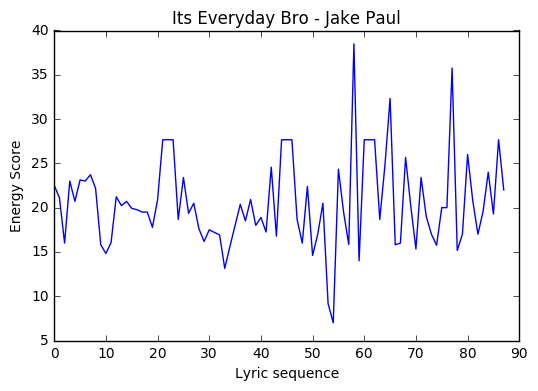

In [89]:
show_energy('BadLyricsExamples/lyric_2.txt', 'Its Everyday Bro - Jake Paul')

18.33126294


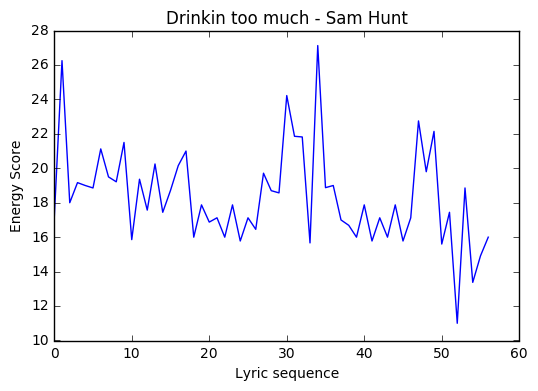

In [90]:
show_energy('BadLyricsExamples/lyric_3.txt', 'Drinkin too much - Sam Hunt')

17.4989247312


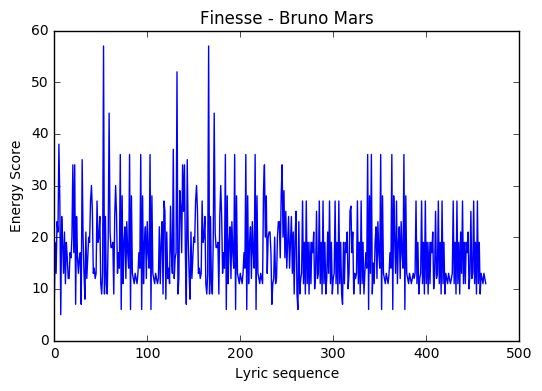

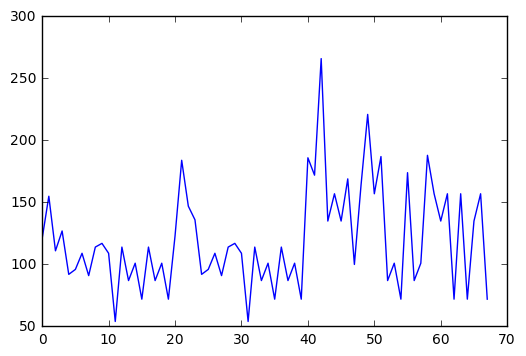

In [101]:
show_energy('BillboardLyrics/finesse.txt', 'Finesse - Bruno Mars')

18.0452961672


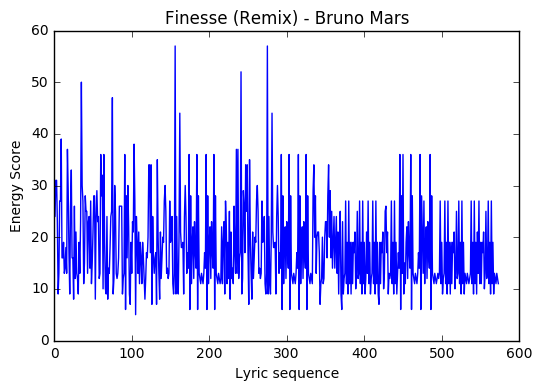

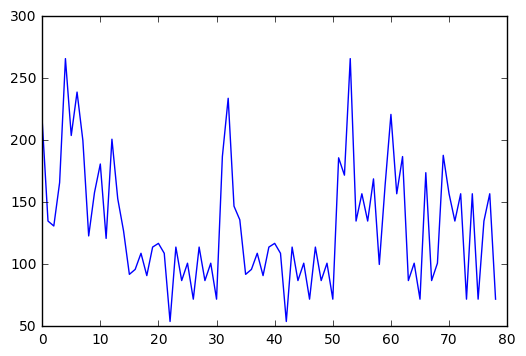

In [102]:
show_energy('BillboardLyrics/finesseremix.txt', 'Finesse (Remix) - Bruno Mars')

19.8846153846


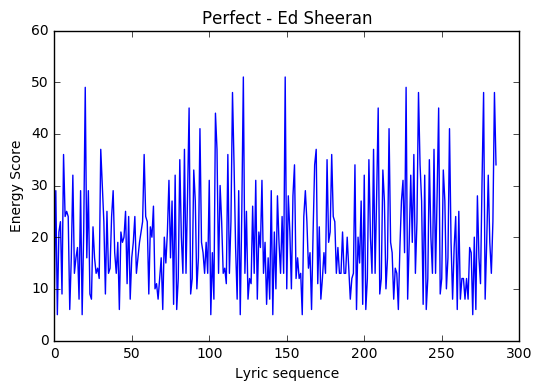

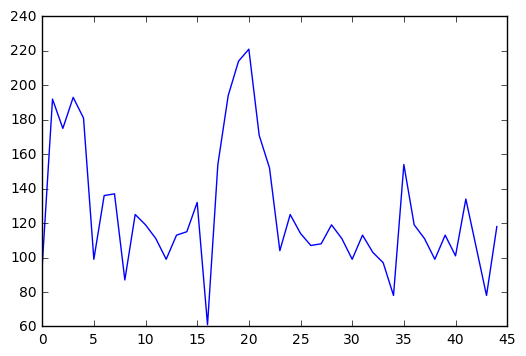

In [104]:
show_energy('BillboardLyrics/perfect.txt', 'Perfect - Ed Sheeran')